# Predicting The Costs Of Used Cars [Machinehack Problem](https://www.machinehack.com/course/predicting-the-costs-of-used-cars-hackathon-by-imarticus/)

#### Problem Statement : **Predicting The Costs Of Used Cars - Hackathon By Imarticus Learning**

#### Metrics Used : RMSE

#### Importing Libraries and reading data

In [772]:
from fastai.imports import *
from fastai.structured import *
import seaborn as sns
import matplotlib.pyplot as plt
from pandas_summary import DataFrameSummary

from IPython.display import display
import xgboost as xgb
from sklearn import metrics

from openpyxl import Workbook

In [773]:
PATH = "/home/shivangmathur/Downloads/Participants_Data_Used_Cars/Participants_Data_Used_Cars/"

In [774]:
df_raw = pd.read_excel(f'{PATH}Data_Train.xlsx')
df_test = pd.read_excel(f'{PATH}Data_Test.xlsx')


#### Feature Engineering

In [775]:
df_raw['MileageValue'] = df_raw.Mileage.str.extract('(\d+(?:\.\d+)?)', \
           expand=False).astype(float).round(2)
df_raw['PowerValue'] = df_raw.Power.str.extract('(\d+(?:\.\d+)?)', \
           expand=False).astype(float).round(2)
df_raw['EngineValue'] = df_raw.Engine.str.extract('(\d+(?:\.\d+)?)', \
           expand=False).astype(float).round(2)
df_raw['New_Price'] = df_raw.New_Price.str.extract('(\d+(?:\.\d+)?)', \
           expand=False).astype(float).round(2)


In [776]:
df_raw.drop(['Mileage'], axis=1,inplace=True)
df_raw.drop(['Power'], axis=1,inplace=True)
df_raw.drop(['Engine'], axis=1,inplace=True)


In [777]:
mean_MileageValue = df_raw['MileageValue'].mean(skipna=True)
df_raw['MileageValue']=df_raw.MileageValue.mask(df_raw.MileageValue == 0,mean_MileageValue)

In [778]:
mean_PowerValue = df_raw['PowerValue'].mean(skipna=True)
df_raw['PowerValue']=df_raw.PowerValue.mask(df_raw.PowerValue == 0,mean_PowerValue)

In [779]:
mean_EngineValue = df_raw['EngineValue'].mean(skipna=True)
df_raw['EngineValue']=df_raw.EngineValue.mask(df_raw.EngineValue == 0,mean_EngineValue)

In [780]:
mean_Seats = df_raw['Seats'].mean(skipna=True)
df_raw['Seats']=df_raw.Seats.mask(df_raw.Seats == 0,mean_Seats)

In [781]:
owner = {'First': 1,'Second': 2,'Third':3,'Fourth & Above':4} 
df_raw.Owner_Type = [owner[item] for item in df_raw.Owner_Type] 

In [782]:
df_raw['MileagePower'] = df_raw['MileageValue']*df_raw['PowerValue']
df_raw['MileageEngine'] = df_raw['MileageValue']*df_raw['EngineValue']
df_raw['KM_Age'] = (2019 - df_raw['Year'])*df_raw['Kilometers_Driven']
df_raw['SeatPower'] = df_raw['Seats']*df_raw['PowerValue']
df_raw['OwnerType_Age'] = (2019 - df_raw['Year'])*df_raw['Owner_Type']
df_raw['Owner_Type_Km'] = df_raw['Owner_Type']*df_raw['Kilometers_Driven']
df_raw['SeatMileage'] = df_raw['Seats']*df_raw['MileageValue']



In [783]:
df_raw['CompanyName'] = df_raw.Name.str.split(' ').str[0]

In [784]:
df_raw.drop(['New_Price'],axis=1,inplace=True)

In [785]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)
display_all(df_raw.tail(100).T)        

,5919,5920,5921,5922,5923,5924,5925,5926,5927,5928,5929,5930,5931,5932,5933,5934,5935,5936,5937,5938,5939,5940,5941,5942,5943,5944,5945,5946,5947,5948,5949,5950,5951,5952,5953,5954,5955,5956,5957,5958,5959,5960,5961,5962,5963,5964,5965,5966,5967,5968,5969,5970,5971,5972,5973,5974,5975,5976,5977,5978,5979,5980,5981,5982,5983,5984,5985,5986,5987,5988,5989,5990,5991,5992,5993,5994,5995,5996,5997,5998,5999,6000,6001,6002,6003,6004,6005,6006,6007,6008,6009,6010,6011,6012,6013,6014,6015,6016,6017,6018
Name,Jaguar F Type 5.0 V8 S,Hyundai Verna 1.6 SX,Mercedes-Benz E-Class 2015-2017 E250 CDI Avant...,Volkswagen Vento Petrol Highline,Skoda Superb Style 2.0 TDI AT,Mahindra Scorpio 1.99 S4 Plus,Skoda Laura Classic 1.8 TSI,Maruti 800 DX BSII,Audi Q5 3.0 TDI Quattro Technology,Mahindra NuvoSport N6,Volkswagen Vento Diesel Highline,Maruti Swift Dzire VXI Optional,Maruti Ertiga VXI,Maruti Alto 800 2016-2019 LXI,Hyundai i20 Magna 1.4 CRDi (Diesel),Ford Ecosport 1.5 DV5 MT Titanium,Maruti Alto K10 LXI CNG,Volkswagen Vento 1.5 TDI Highline,Mahindra Scorpio VLX 2WD Airbag BSIII,Ford Figo Aspire 1.5 TDCi Titanium Plus,Toyota Innova 2.5 G (Diesel) 8 Seater,Maruti Dzire LDI,Renault KWID RXL,Ford Endeavour 2.5L 4X2 MT,Mahindra Jeep MM 540 DP,Ford EcoSport 1.0 Ecoboost Titanium Plus,Hyundai Creta 1.6 CRDi SX,BMW 5 Series 2013-2017 530d M Sport,Maruti Ertiga VXI AT Petrol,Skoda Laura L and K AT,Chevrolet Beat LS,Audi Q3 2.0 TDI,Honda City 1.5 V MT,Maruti Swift Lxi BSIII,Ford Figo Diesel EXI,Toyota Fortuner 4x4 AT,Mercedes-Benz New C-Class 200 CDI Classic,Toyota Innova 2.5 GX (Diesel) 7 Seater,Honda City 1.5 EXI,Honda Amaze S i-Dtech,Toyota Corolla Altis 1.8 G CVT,Tata Indica Vista Quadrajet VX,Mahindra XUV500 W8 2WD,Maruti Ritz VDi,Mercedes-Benz New C-Class C 200 AVANTGARDE,Hyundai Verna VTVT 1.6 AT SX Option,Mercedes-Benz New C-Class C 250 CDI Elegance,Maruti Wagon R VXI BS IV,Maruti Ertiga VXI,Skoda Rapid Ultima 1.6 TDI Elegance,Toyota Innova 2.5 V Diesel 8-seater,Mercedes-Benz GLA Class 200 Sport,Volkswagen Polo 1.5 TDI Highline,Hyundai Santro Xing GL,Hyundai Verna 1.6 CRDi EX MT,Volkswagen Ameo 1.2 MPI Highline,Hyundai i20 Asta Option 1.2,Maruti Wagon R LX BSIII,Tata Indica LEI,Mahindra Xylo D4,ISUZU D-MAX V-Cross 4X4,Hyundai i20 2015-2017 Magna,Maruti Baleno Alpha,Tata Hexa XTA,Volkswagen Polo Petrol Comfortline 1.2L,Mercedes-Benz New C-Class C 200 CGI Elegance,Toyota Etios GD,Hyundai Getz GLS,Tata Tiago 1.2 Revotron XT,Renault Duster 85PS Diesel RxL Option,Audi A4 35 TDI Premium Plus,Tata New Safari DICOR 2.2 VX 4x2,Maruti Swift VDI,Skoda Superb Elegance 1.8 TSI AT,Hyundai Elantra SX,Honda City 1.5 E MT,Renault Duster 85PS Diesel RxL Explore,Jaguar XF 2.2 Litre Luxury,Maruti Wagon R Duo Lxi,Volkswagen Polo IPL II 1.2 Petrol Highline,Tata Bolt Revotron XT,Hyundai i20 Sportz 1.2,Audi A6 2011-2015 2.0 TDI,Volkswagen Vento 1.6 Highline,Maruti Celerio VXI,Hyundai Getz GLE,Maruti Vitara Brezza VDi,Mercedes-Benz M-Class ML 320 CDI,Maruti Swift Dzire Vdi BSIV,Porsche Panamera Diesel,Toyota Camry Hybrid,Honda Brio 1.2 VX MT,Skoda Superb 3.6 V6 FSI,Toyota Innova 2.5 V Diesel 7-seater,Honda Amaze VX i-DTEC,Maruti Swift VDI,Hyundai Xcent 1.1 CRDi S,Mahindra Xylo D4 BSIV,Maruti Wagon R VXI,Chevrolet Beat Diesel
Location,Hyderabad,Kochi,Mumbai,Kochi,Mumbai,Kochi,Pune,Pune,Coimbatore,Coimbatore,Chennai,Chennai,Mumbai,Chennai,Kochi,Kolkata,Pune,Bangalore,Bangalore,Kochi,Mumbai,Pune,Pune,Jaipur,Chennai,Delhi,Hyderabad,Bangalore,Mumbai,Hyderabad,Kolkata,Bangalore,Pune,Pune,Jaipur,Chennai,Pune,Chennai,Coimbatore,Jaipur,Delhi,Hyderabad,Mumbai,Kolkata,Mumbai,Mumbai,Hyderabad,Hyderabad,Bangalore,Hyderabad,Delhi,Kochi,Hyderabad,Mumbai,Kolkata,Ahmedabad,Coimbatore,Delhi,Pune,Hyderabad,Jaipur,Pune,Mumbai,Jaipur,Kolkata,Mumbai,Delhi,Jaipur,Kochi,Mumbai,Coimbatore,Pune,Hyderabad,Mumbai,Mumbai,Pune,Pune,Kochi,Jaipur,Pune,Chennai,Bangalore,Kochi,Mumbai,Bangalore,Coimbatore,Pune,Mumbai,Delhi,Hyderabad,Mumbai,Delhi,Hyderabad,Coimbatore,Coimbatore,Delhi,Jaipur,Jaipur,Kolkata,H

In [786]:
df_test['MileageValue'] = df_test.Mileage.str.extract('(\d+(?:\.\d+)?)', \
           expand=False).astype(float).round(2)
df_test['PowerValue'] = df_test.Power.str.extract('(\d+(?:\.\d+)?)', \
           expand=False).astype(float).round(2)
df_test['EngineValue'] = df_test.Engine.str.extract('(\d+(?:\.\d+)?)', \
           expand=False).astype(float).round(2)
df_test['New_Price'] = df_test.New_Price.str.extract('(\d+(?:\.\d+)?)', \
           expand=False).astype(float).round(2)
#df_test["New_Price"] = df_test["New_Price"].replace(np.nan,df_test['New_Price'].mean())

df_test.drop(['Mileage'], axis=1,inplace=True)
df_test.drop(['Power'], axis=1,inplace=True)
df_test.drop(['Engine'], axis=1,inplace=True)
df_test.drop(['New_Price'],axis=1,inplace=True)


df_test['MileageValue']=df_test.MileageValue.mask(df_test.MileageValue == 0,mean_MileageValue)


df_test['PowerValue']=df_test.PowerValue.mask(df_test.PowerValue == 0,mean_PowerValue)


df_test['EngineValue']=df_test.EngineValue.mask(df_test.EngineValue == 0,mean_EngineValue)


df_test['Seats']=df_test.Seats.mask(df_test.Seats == 0,mean_Seats)

df_test['MileagePower'] = df_test['MileageValue']*df_test['PowerValue']
df_test['MileageEngine'] = df_test['MileageValue']*df_test['EngineValue']
df_test['KM_Age'] = (2019 - df_test['Year'])*df_test['Kilometers_Driven']
df_test['SeatPower'] = df_test['Seats']*df_test['PowerValue']

df_test.Owner_Type = [owner[item] for item in df_test.Owner_Type] 
df_test['OwnerType_Age'] = (2019 - df_test['Year'])*df_test['Owner_Type']
df_test['Owner_Type_Km'] = df_test['Owner_Type']*df_test['Kilometers_Driven']
df_test['SeatMileage'] = df_test['Seats']*df_test['MileageValue']
df_test['CompanyName'] = df_test.Name.str.split(' ').str[0]

#### Using techniques of FastAI

In [787]:
train_cats(df_raw)
apply_cats(df=df_test, trn=df_raw)

In [788]:
df_trn2, y_trn, nas = proc_df(df_raw, 'Price', max_n_cat=35)
df_test2,_,nas= proc_df(df_test,max_n_cat=35,na_dict=nas)

In [789]:
df_trn2.head()

,Name,Year,Kilometers_Driven,Owner_Type,Seats,MileageValue,PowerValue,EngineValue,MileagePower,MileageEngine,...,CompanyName_Nissan,CompanyName_Porsche,CompanyName_Renault,CompanyName_Skoda,CompanyName_Smart,CompanyName_Tata,CompanyName_Toyota,CompanyName_Volkswagen,CompanyName_Volvo,CompanyName_nan
0,1201,2010,72000,1,5.0,26.60,58.16,998.0,1547.0560,26546.80,...,0,0,0,0,0,0,0,0,0,0
1,513,2015,41000,1,5.0,19.67,126.20,1582.0,2482.3540,31117.94,...,0,0,0,0,0,0,0,0,0,0
2,487,2011,46000,1,5.0,18.20,88.70,1199.0,1614.3400,21821.80,...,0,0,0,0,0,0,0,0,0,0
3,1060,2012,87000,1,7.0,20.77,88.76,1248.0,1843.5452,25920.96,...,0,0,0,0,0,0,0,0,0,0
4,24,2013,40670,2,5.0,15.20,140.80,1968.0,2140.1600,29913.60,...,0,0,0,0,0,0,0,0,0,0


#### Creating training and validation set

In [791]:
def split_vals(a,n): return a[:n].copy(), a[n:].copy()

n_valid = 0  
n_trn = len(df_trn2)-n_valid
raw_train, raw_valid = split_vals(df_raw, n_trn)
X_train, X_valid = split_vals(df_trn2, n_trn)
y_train, y_valid = split_vals(y_trn, n_trn)
X_train.shape, y_train.shape, X_valid.shape


((6019, 76), (6019,), (0, 76))

#### Building the model using xgBoost and making predictions

In [804]:
params = {
    'booster': 'gbtree', 
    'objective':'reg:squarederror',#egression task
    'subsample': 0.7,#% of data to grow trees and prevent overfitting
    'colsample_bytree': 0.7, # 89% of features used
    'eta': 0.119,
    'gamma':6,
    
'max_depth':18,
    
    'seed': 42} # for reproducible results

dtrain = xgb.DMatrix(X_train, y_train)
#dvalid = xgb.DMatrix(X_valid,y_valid)


watchlist = [(dtrain, 'train')]

xgb_model = xgb.train(params, dtrain,2216,early_stopping_rounds=200,evals= watchlist,verbose_eval=True)


[0]	train-rmse:12.8276
Will train until train-rmse hasn't improved in 200 rounds.
[1]	train-rmse:11.4815
[2]	train-rmse:10.3073
[3]	train-rmse:9.27832
[4]	train-rmse:8.35157
[5]	train-rmse:7.52834
[6]	train-rmse:6.79529
[7]	train-rmse:6.14531
[8]	train-rmse:5.57425
[9]	train-rmse:5.06753
[10]	train-rmse:4.6257
[11]	train-rmse:4.21627
[12]	train-rmse:3.85099
[13]	train-rmse:3.5356
[14]	train-rmse:3.25237
[15]	train-rmse:3.00308
[16]	train-rmse:2.77165
[17]	train-rmse:2.558
[18]	train-rmse:2.37611
[19]	train-rmse:2.22545
[20]	train-rmse:2.07679
[21]	train-rmse:1.93574
[22]	train-rmse:1.82386
[23]	train-rmse:1.71729
[24]	train-rmse:1.62107
[25]	train-rmse:1.53083
[26]	train-rmse:1.46132
[27]	train-rmse:1.38553
[28]	train-rmse:1.32479
[29]	train-rmse:1.27098
[30]	train-rmse:1.2154
[31]	train-rmse:1.16821
[32]	train-rmse:1.12517
[33]	train-rmse:1.08697
[34]	train-rmse:1.04613
[35]	train-rmse:1.00797
[36]	train-rmse:0.982108
[37]	train-rmse:0.962564
[38]	train-rmse:0.937338
[39]	train-rmse:0

[320]	train-rmse:0.588021
[321]	train-rmse:0.588021
[322]	train-rmse:0.588021
[323]	train-rmse:0.588021
[324]	train-rmse:0.588021
[325]	train-rmse:0.588022
[326]	train-rmse:0.588022
[327]	train-rmse:0.588021
[328]	train-rmse:0.588022
[329]	train-rmse:0.588021
[330]	train-rmse:0.588022
[331]	train-rmse:0.588021
[332]	train-rmse:0.588021
[333]	train-rmse:0.587571
[334]	train-rmse:0.587573
[335]	train-rmse:0.587571
[336]	train-rmse:0.587571
[337]	train-rmse:0.587572
[338]	train-rmse:0.587571
[339]	train-rmse:0.587571
[340]	train-rmse:0.587216
[341]	train-rmse:0.586399
[342]	train-rmse:0.5864
[343]	train-rmse:0.586399
[344]	train-rmse:0.586399
[345]	train-rmse:0.5864
[346]	train-rmse:0.586399
[347]	train-rmse:0.5864
[348]	train-rmse:0.586399
[349]	train-rmse:0.586402
[350]	train-rmse:0.586402
[351]	train-rmse:0.586403
[352]	train-rmse:0.586405
[353]	train-rmse:0.586408
[354]	train-rmse:0.586406
[355]	train-rmse:0.586172
[356]	train-rmse:0.586173
[357]	train-rmse:0.586172
[358]	train-rmse:0

[637]	train-rmse:0.57307
[638]	train-rmse:0.57307
[639]	train-rmse:0.573071
[640]	train-rmse:0.573071
[641]	train-rmse:0.573071
[642]	train-rmse:0.573071
[643]	train-rmse:0.57307
[644]	train-rmse:0.57307
[645]	train-rmse:0.57307
[646]	train-rmse:0.57307
[647]	train-rmse:0.571965
[648]	train-rmse:0.571966
[649]	train-rmse:0.571965
[650]	train-rmse:0.571966
[651]	train-rmse:0.571965
[652]	train-rmse:0.571691
[653]	train-rmse:0.571691
[654]	train-rmse:0.571691
[655]	train-rmse:0.571691
[656]	train-rmse:0.571692
[657]	train-rmse:0.571691
[658]	train-rmse:0.571693
[659]	train-rmse:0.571694
[660]	train-rmse:0.571692
[661]	train-rmse:0.571692
[662]	train-rmse:0.571693
[663]	train-rmse:0.571693
[664]	train-rmse:0.571693
[665]	train-rmse:0.571694
[666]	train-rmse:0.571695
[667]	train-rmse:0.571692
[668]	train-rmse:0.571691
[669]	train-rmse:0.571691
[670]	train-rmse:0.571692
[671]	train-rmse:0.571692
[672]	train-rmse:0.571692
[673]	train-rmse:0.571692
[674]	train-rmse:0.571522
[675]	train-rmse:0

[953]	train-rmse:0.562515
[954]	train-rmse:0.562516
[955]	train-rmse:0.562517
[956]	train-rmse:0.562516
[957]	train-rmse:0.562517
[958]	train-rmse:0.562516
[959]	train-rmse:0.562517
[960]	train-rmse:0.562515
[961]	train-rmse:0.562516
[962]	train-rmse:0.562515
[963]	train-rmse:0.562517
[964]	train-rmse:0.562518
[965]	train-rmse:0.562518
[966]	train-rmse:0.562516
[967]	train-rmse:0.562516
[968]	train-rmse:0.562516
[969]	train-rmse:0.562516
[970]	train-rmse:0.562519
[971]	train-rmse:0.562519
[972]	train-rmse:0.562516
[973]	train-rmse:0.562518
[974]	train-rmse:0.562517
[975]	train-rmse:0.562515
[976]	train-rmse:0.562515
[977]	train-rmse:0.562515
[978]	train-rmse:0.562516
[979]	train-rmse:0.562517
[980]	train-rmse:0.562201
[981]	train-rmse:0.562201
[982]	train-rmse:0.562204
[983]	train-rmse:0.562202
[984]	train-rmse:0.562202
[985]	train-rmse:0.562203
[986]	train-rmse:0.562203
[987]	train-rmse:0.562202
[988]	train-rmse:0.562203
[989]	train-rmse:0.562202
[990]	train-rmse:0.561913
[991]	train-

[1260]	train-rmse:0.558094
[1261]	train-rmse:0.558094
[1262]	train-rmse:0.558094
[1263]	train-rmse:0.558094
[1264]	train-rmse:0.558095
[1265]	train-rmse:0.558096
[1266]	train-rmse:0.558095
[1267]	train-rmse:0.558095
[1268]	train-rmse:0.558094
[1269]	train-rmse:0.558094
[1270]	train-rmse:0.558094
[1271]	train-rmse:0.558095
[1272]	train-rmse:0.558093
[1273]	train-rmse:0.558093
[1274]	train-rmse:0.558093
[1275]	train-rmse:0.558093
[1276]	train-rmse:0.558093
[1277]	train-rmse:0.558094
[1278]	train-rmse:0.558094
[1279]	train-rmse:0.558094
[1280]	train-rmse:0.558095
[1281]	train-rmse:0.558093
[1282]	train-rmse:0.558094
[1283]	train-rmse:0.558095
[1284]	train-rmse:0.558095
[1285]	train-rmse:0.558095
[1286]	train-rmse:0.558094
[1287]	train-rmse:0.558093
[1288]	train-rmse:0.558094
[1289]	train-rmse:0.558095
[1290]	train-rmse:0.558095
[1291]	train-rmse:0.558094
[1292]	train-rmse:0.558093
[1293]	train-rmse:0.558093
[1294]	train-rmse:0.558093
[1295]	train-rmse:0.558094
[1296]	train-rmse:0.558094
[

[1565]	train-rmse:0.555175
[1566]	train-rmse:0.555175
[1567]	train-rmse:0.555175
[1568]	train-rmse:0.555175
[1569]	train-rmse:0.555175
[1570]	train-rmse:0.555175
[1571]	train-rmse:0.555176
[1572]	train-rmse:0.555175
[1573]	train-rmse:0.555176
[1574]	train-rmse:0.555177
[1575]	train-rmse:0.55497
[1576]	train-rmse:0.55497
[1577]	train-rmse:0.55497
[1578]	train-rmse:0.554969
[1579]	train-rmse:0.554969
[1580]	train-rmse:0.554969
[1581]	train-rmse:0.55497
[1582]	train-rmse:0.554969
[1583]	train-rmse:0.554969
[1584]	train-rmse:0.554969
[1585]	train-rmse:0.554969
[1586]	train-rmse:0.554969
[1587]	train-rmse:0.554969
[1588]	train-rmse:0.55497
[1589]	train-rmse:0.554969
[1590]	train-rmse:0.554969
[1591]	train-rmse:0.554969
[1592]	train-rmse:0.554969
[1593]	train-rmse:0.554969
[1594]	train-rmse:0.554969
[1595]	train-rmse:0.554969
[1596]	train-rmse:0.554969
[1597]	train-rmse:0.554971
[1598]	train-rmse:0.55497
[1599]	train-rmse:0.554973
[1600]	train-rmse:0.554971
[1601]	train-rmse:0.554972
[1602]	

[1871]	train-rmse:0.551249
[1872]	train-rmse:0.55125
[1873]	train-rmse:0.551249
[1874]	train-rmse:0.551249
[1875]	train-rmse:0.551249
[1876]	train-rmse:0.551249
[1877]	train-rmse:0.55125
[1878]	train-rmse:0.551249
[1879]	train-rmse:0.551249
[1880]	train-rmse:0.55125
[1881]	train-rmse:0.551249
[1882]	train-rmse:0.551249
[1883]	train-rmse:0.551249
[1884]	train-rmse:0.551249
[1885]	train-rmse:0.551249
[1886]	train-rmse:0.551249
[1887]	train-rmse:0.551249
[1888]	train-rmse:0.551249
[1889]	train-rmse:0.551249
[1890]	train-rmse:0.551249
[1891]	train-rmse:0.551249
[1892]	train-rmse:0.551249
[1893]	train-rmse:0.55125
[1894]	train-rmse:0.551249
[1895]	train-rmse:0.551249
[1896]	train-rmse:0.551249
[1897]	train-rmse:0.55125
[1898]	train-rmse:0.551249
[1899]	train-rmse:0.551249
[1900]	train-rmse:0.55125
[1901]	train-rmse:0.551249
[1902]	train-rmse:0.551249
[1903]	train-rmse:0.551249
[1904]	train-rmse:0.551249
[1905]	train-rmse:0.551249
[1906]	train-rmse:0.551249
[1907]	train-rmse:0.551251
[1908]	

[2177]	train-rmse:0.546455
[2178]	train-rmse:0.546455
[2179]	train-rmse:0.546455
[2180]	train-rmse:0.546454
[2181]	train-rmse:0.546454
[2182]	train-rmse:0.546454
[2183]	train-rmse:0.546454
[2184]	train-rmse:0.546457
[2185]	train-rmse:0.546456
[2186]	train-rmse:0.546457
[2187]	train-rmse:0.546456
[2188]	train-rmse:0.546457
[2189]	train-rmse:0.546456
[2190]	train-rmse:0.546454
[2191]	train-rmse:0.546455
[2192]	train-rmse:0.546454
[2193]	train-rmse:0.546455
[2194]	train-rmse:0.546455
[2195]	train-rmse:0.546454
[2196]	train-rmse:0.546455
[2197]	train-rmse:0.546455
[2198]	train-rmse:0.546454
[2199]	train-rmse:0.546454
[2200]	train-rmse:0.546455
[2201]	train-rmse:0.546455
[2202]	train-rmse:0.546455
[2203]	train-rmse:0.546454
[2204]	train-rmse:0.546455
[2205]	train-rmse:0.546456
[2206]	train-rmse:0.546455
[2207]	train-rmse:0.546454
[2208]	train-rmse:0.546455
[2209]	train-rmse:0.546454
[2210]	train-rmse:0.546455
[2211]	train-rmse:0.546454
[2212]	train-rmse:0.546455
[2213]	train-rmse:0.546455
[

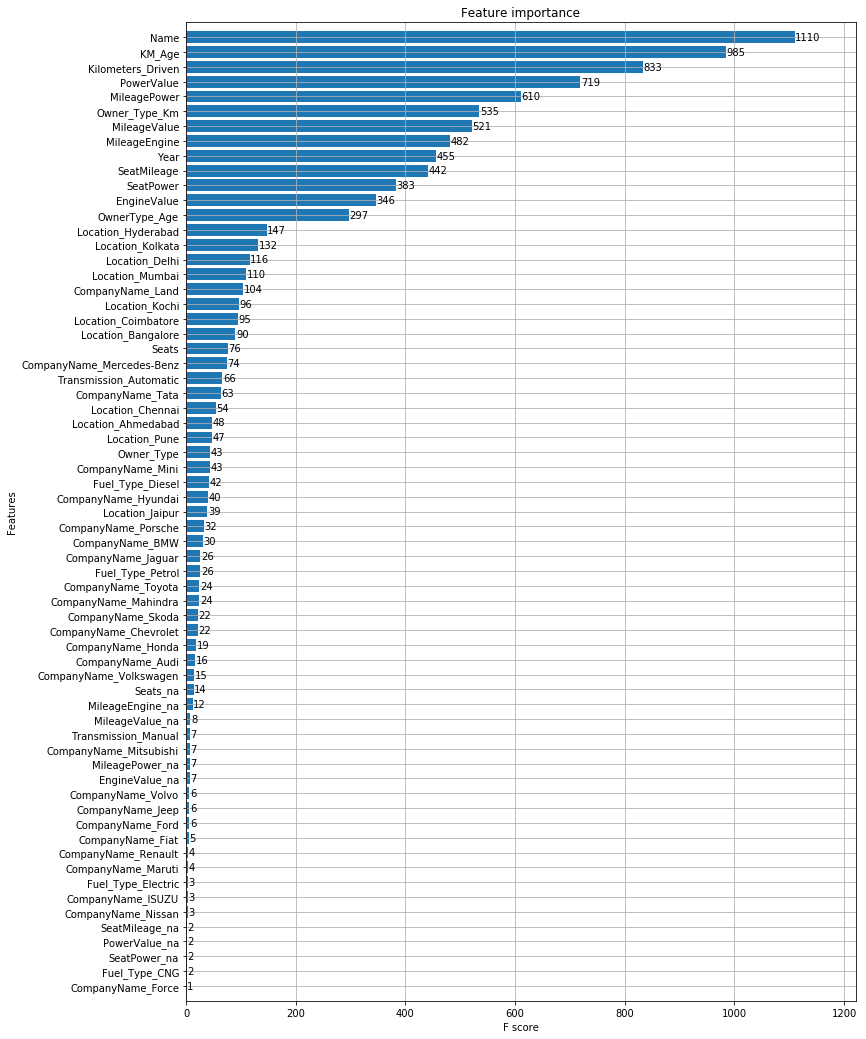

In [805]:
from matplotlib import pyplot
from xgboost import plot_importance
fig, ax = plt.subplots(figsize=(12,18))
xgb.plot_importance(xgb_model, max_num_features=100, height=0.8, ax=ax)
pyplot.show()

In [806]:
test = xgb.DMatrix(df_test2)

pred_x = xgb_model.predict(test)

pred_x

array([ 4.68184,  2.94571, 17.11668, ...,  2.87053,  5.27878, 20.3917 ], dtype=float32)